# Smart Product Pricing Challenge

# Imports

In [2]:
import pandas as pd
import os
import urllib
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, ViTImageProcessor, ViTModel
from sentence_transformers import SentenceTransformer
from PIL import Image

# Folder/File

In [3]:
ROOT_FOLDER = "/content"
DATASET_FOLDER = ROOT_FOLDER
DATASET_FILE_PATH = os.path.join(DATASET_FOLDER, "train.csv")
DATASET_IMAGES_FOLDER = os.path.join(ROOT_FOLDER, "training_images")

os.makedirs(DATASET_IMAGES_FOLDER, exist_ok=True)

# Load Test Dataset

In [4]:
df = pd.read_csv(DATASET_FILE_PATH, nrows=4000)
df.head()

,sample_id,catalog_content,image_link,price
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, ...",https://m.media-amazon.com/images/I/51mo8htwTH...,4.89
1,198967,"Item Name: Salerno Cookies, The Original Butte...",https://m.media-amazon.com/images/I/71YtriIHAA...,13.12
2,261251,"Item Name: Bear Creek Hearty Soup Bowl, Creamy...",https://m.media-amazon.com/images/I/51+PFEe-w-...,1.97
3,55858,Item Name: Judee’s Blue Cheese Powder 11.25 oz...,https://m.media-amazon.com/images/I/41mu0HAToD...,30.34
4,292686,"Item Name: kedem Sherry Cooking Wine, 12.7 Oun...",https://m.media-amazon.com/images/I/41sA037+Qv...,66.49


In [5]:
df.columns.to_list()

['sample_id', 'catalog_content', 'image_link', 'price']

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sample_id        4000 non-null   int64  
 1   catalog_content  4000 non-null   object 
 2   image_link       4000 non-null   object 
 3   price            4000 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 125.1+ KB


In [7]:
df.shape

(4000, 4)

In [8]:
df['price'].describe()

,price
count,4000.000000
mean,23.939789
std,32.187473
min,0.130000
25%,6.740000
50%,13.990000
75%,28.990000
max,441.980000


In [9]:
df.isnull().sum()

,0
sample_id,0
catalog_content,0
image_link,0
price,0


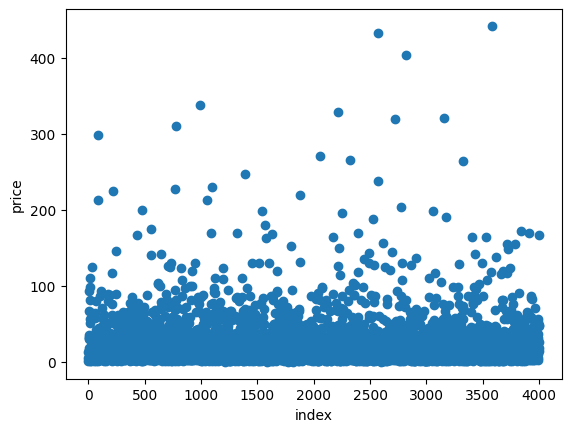

In [10]:
plt.scatter(df.index, df['price'])
plt.xlabel('index')
plt.ylabel('price')
plt.show()

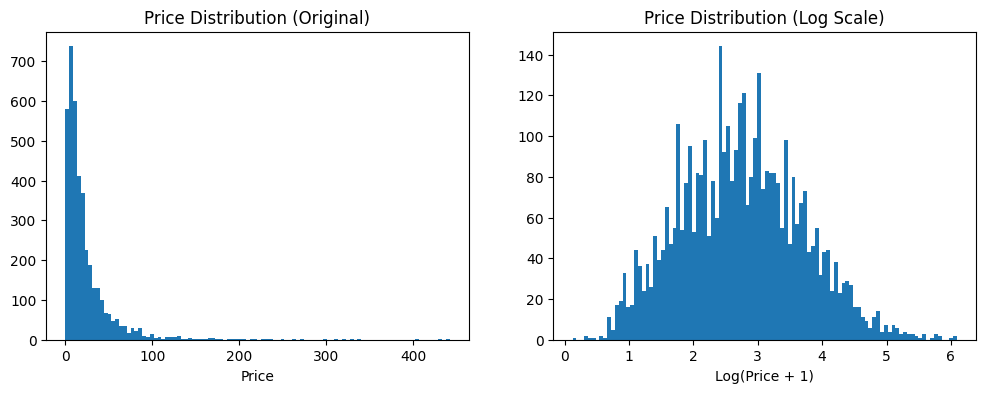

In [11]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['price'], bins=100)
plt.xlabel('Price')
plt.title('Price Distribution (Original)')

plt.subplot(1, 2, 2)
plt.hist(np.log1p(df['price']), bins=100)
plt.xlabel('Log(Price + 1)')
plt.title('Price Distribution (Log Scale)')
plt.show()

# Download Images

In [12]:
def download_image(image_link, savefolder):
    if isinstance(image_link, str):
        filename = Path(image_link).name
        image_save_path = os.path.join(savefolder, filename)
        if not os.path.exists(image_save_path):
            try:
                urllib.request.urlretrieve(image_link, image_save_path)
            except Exception as ex:
                print("Warning: Not able to download - {}\n{}".format(image_link, ex))
        else:
            return
    return

In [13]:
if len(os.listdir(DATASET_IMAGES_FOLDER)) == 0:
    for row in tqdm(df.itertuples(), total=len(df), desc="Downloading Images"):
        image_link = row.image_link
        download_image(image_link, DATASET_IMAGES_FOLDER)
else:
    print(f"Images are already downloaded in {DATASET_IMAGES_FOLDER}")

# Pre-Processing

In [14]:
def pre_process(df):
    df = df.copy()

    # Clean text
    df['catalog_content_clean'] = df['catalog_content'].apply(
        lambda x: re.sub(r'\s+', ' ', str(x).replace('\n', ' ')).lower().strip()
    )

    # Extract the single Value–Unit pair at the end of text
    pattern = r'value:\s*([\d\.]+)\s*unit:\s*([\w\s\.\(\)]+)\s*$'
    df[['value', 'unit']] = df['catalog_content_clean'].apply(
        lambda text: pd.Series(re.search(pattern, text).groups()) if re.search(pattern, text) else pd.Series([None, None])
    )

    # Convert value to float
    df['value'] = df['value'].astype(float)

    return df

In [15]:
new_df = pre_process(df)

# Convert price to log_price
new_df['log_price'] = np.log1p(new_df['price'])

new_df.head()

,sample_id,catalog_content,image_link,price,catalog_content_clean,value,unit,log_price
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, ...",https://m.media-amazon.com/images/I/51mo8htwTH...,4.89,"item name: la victoria green taco sauce mild, ...",72.00,fl oz,1.773256
1,198967,"Item Name: Salerno Cookies, The Original Butte...",https://m.media-amazon.com/images/I/71YtriIHAA...,13.12,"item name: salerno cookies, the original butte...",32.00,ounce,2.647592
2,261251,"Item Name: Bear Creek Hearty Soup Bowl, Creamy...",https://m.media-amazon.com/images/I/51+PFEe-w-...,1.97,"item name: bear creek hearty soup bowl, creamy...",11.40,ounce,1.088562
3,55858,Item Name: Judee’s Blue Cheese Powder 11.25 oz...,https://m.media-amazon.com/images/I/41mu0HAToD...,30.34,item name: judee’s blue cheese powder 11.25 oz...,11.25,ounce,3.444895
4,292686,"Item Name: kedem Sherry Cooking Wine, 12.7 Oun...",https://m.media-amazon.com/images/I/41sA037+Qv...,66.49,"item name: kedem sherry cooking wine, 12.7 oun...",12.00,count,4.211979


In [16]:
new_df['log_price'].describe()

,log_price
count,4000.000000
mean,2.740582
std,0.951652
min,0.122218
25%,2.046402
50%,2.707383
75%,3.400864
max,6.093525


In [17]:
new_df.isnull().sum()

,0
sample_id,0
catalog_content,0
image_link,0
price,0
catalog_content_clean,0
value,59
unit,59
log_price,0


In [18]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sample_id              4000 non-null   int64  
 1   catalog_content        4000 non-null   object 
 2   image_link             4000 non-null   object 
 3   price                  4000 non-null   float64
 4   catalog_content_clean  4000 non-null   object 
 5   value                  3941 non-null   float64
 6   unit                   3941 non-null   object 
 7   log_price              4000 non-null   float64
dtypes: float64(3), int64(1), object(4)
memory usage: 250.1+ KB


In [19]:
new_df['value'] = new_df['value'].fillna(0)
new_df['unit'] = new_df['unit'].fillna('unknown')

In [20]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sample_id              4000 non-null   int64  
 1   catalog_content        4000 non-null   object 
 2   image_link             4000 non-null   object 
 3   price                  4000 non-null   float64
 4   catalog_content_clean  4000 non-null   object 
 5   value                  4000 non-null   float64
 6   unit                   4000 non-null   object 
 7   log_price              4000 non-null   float64
dtypes: float64(3), int64(1), object(4)
memory usage: 250.1+ KB


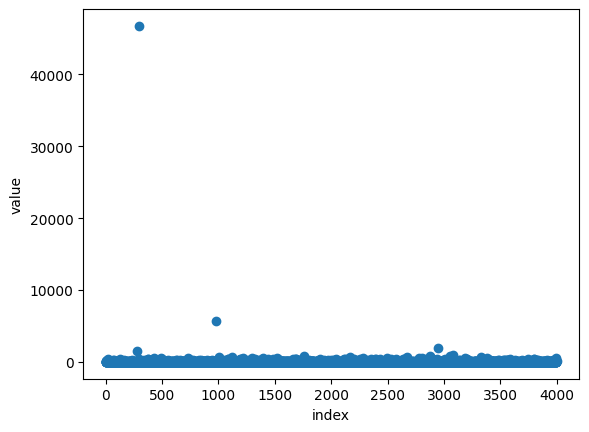

In [21]:
plt.scatter(new_df.index, new_df['value'])
plt.xlabel('index')
plt.ylabel('value')
plt.show()

## Normalization

- Convert every unit to one of 3 standardized metrics:
    - `volume_ml` → for liquids
    - `weight_g` → for solids
    - `count` → for discrete items
- Handle noisy or duplicate spellings like "fl oz", "fl.oz", "fluid ounces", etc.
- Default to `count = 1` for `unknown`/miscellaneous cases.

In [22]:
unit_counts = new_df['unit'].dropna().str.lower().value_counts().head(100)
print("Total Units: ", len(unit_counts))
print(unit_counts)

Total Units:  19
unit
ounce          2203
count          1048
fl oz           594
oz               66
unknown          59
pound            11
fluid ounce       3
ounces            2
gram              2
fl. oz            2
ct                2
lb                1
grams             1
liters            1
each              1
gramm             1
millilitre        1
jar               1
bottle            1
Name: count, dtype: int64


In [23]:
unit_map = {
    # ---- WEIGHT ----
    "ounce": ("weight_g", 28.3495),
    "oz": ("weight_g", 28.3495),
    "ounces": ("weight_g", 28.3495),
    "pound": ("weight_g", 453.592),
    "pounds": ("weight_g", 453.592),
    "lb": ("weight_g", 453.592),
    "gram": ("weight_g", 1.0),
    "grams": ("weight_g", 1.0),
    "gramm": ("weight_g", 1.0),
    "gr": ("weight_g", 1.0),
    "kg": ("weight_g", 1000.0),

    # ---- VOLUME ----
    "fl oz": ("volume_ml", 29.5735),
    "fl. oz": ("volume_ml", 29.5735),
    "fl.oz": ("volume_ml", 29.5735),
    "fl. oz.": ("volume_ml", 29.5735),
    "fl ounce": ("volume_ml", 29.5735),
    "fluid ounce": ("volume_ml", 29.5735),
    "fluid ounces": ("volume_ml", 29.5735),
    "fluid ounce(s)": ("volume_ml", 29.5735),
    "millilitre": ("volume_ml", 1.0),
    "milliliter": ("volume_ml", 1.0),
    "mililitro": ("volume_ml", 1.0),
    "ml": ("volume_ml", 1.0),
    "ltr": ("volume_ml", 1000.0),
    "liters": ("volume_ml", 1000.0),

    # ---- COUNT / PACK ----
    "count": ("count", 1.0),
    "ct": ("count", 1.0),
    "pack": ("count", 1.0),
    "packs": ("count", 1.0),
    "piece": ("count", 1.0),
    "pieces": ("count", 1.0),
    "unit": ("count", 1.0),
    "units": ("count", 1.0),
    "bag": ("count", 1.0),
    "bottle": ("count", 1.0),
    "bottles": ("count", 1.0),
    "can": ("count", 1.0),
    "jar": ("count", 1.0),
    "box": ("count", 1.0),
    "carton": ("count", 1.0),
    "capsule": ("count", 1.0),
    "pouch": ("count", 1.0),
    "per carton": ("count", 1.0),
    "per package": ("count", 1.0),
    "per box": ("count", 1.0),
    "paper cupcake liners": ("count", 1.0),
    "bucket": ("count", 1.0),
    "sq ft": ("count", 1.0),
    "foot": ("count", 1.0),
    "tea bags": ("count", 1.0),

    # ---- UNKNOWN ----
    "unknown": ("count", 1.0),
    "product_weight": ("weight_g", 1.0),
    "1": ("count", 1.0),
    "8": ("count", 1.0),
    "24": ("count", 1.0),
    "unità": ("count", 1.0),
}

In [24]:
def normalize(row, unit_map):
    val = row['value']
    unit = str(row['unit']).lower().strip()
    if pd.isna(val) or val == 0 or unit == 'nan':
        return pd.Series({'volume_ml': 0, 'weight_g': 0, 'count': 0})

    category, multiplier = unit_map.get(unit, ('count', 1.0))
    volume_ml = weight_g = count = 0

    if category == 'volume_ml':
        volume_ml = val * multiplier
    elif category == 'weight_g':
        weight_g = val * multiplier
    elif category == 'count':
        count = val * multiplier

    return pd.Series({'volume_ml': volume_ml, 'weight_g': weight_g, 'count': count})

In [25]:
new_df[['volume_ml', 'weight_g', 'count']] = new_df.apply(
    normalize, axis=1, unit_map=unit_map
)

In [26]:
new_df.head(10)

,sample_id,catalog_content,image_link,price,catalog_content_clean,value,unit,log_price,volume_ml,weight_g,count
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, ...",https://m.media-amazon.com/images/I/51mo8htwTH...,4.89,"item name: la victoria green taco sauce mild, ...",72.00,fl oz,1.773256,2129.292,0.000000,0.0
1,198967,"Item Name: Salerno Cookies, The Original Butte...",https://m.media-amazon.com/images/I/71YtriIHAA...,13.12,"item name: salerno cookies, the original butte...",32.00,ounce,2.647592,0.000,907.184000,0.0
2,261251,"Item Name: Bear Creek Hearty Soup Bowl, Creamy...",https://m.media-amazon.com/images/I/51+PFEe-w-...,1.97,"item name: bear creek hearty soup bowl, creamy...",11.40,ounce,1.088562,0.000,323.184300,0.0
3,55858,Item Name: Judee’s Blue Cheese Powder 11.25 oz...,https://m.media-amazon.com/images/I/41mu0HAToD...,30.34,item name: judee’s blue cheese powder 11.25 oz...,11.25,ounce,3.444895,0.000,318.931875,0.0
4,292686,"Item Name: kedem Sherry Cooking Wine, 12.7 Oun...",https://m.media-amazon.com/images/I/41sA037+Qv...,66.49,"item name: kedem sherry cooking wine, 12.7 oun...",12.00,count,4.211979,0.000,0.000000,12.0
5,9259,"Item Name: Member's Mark Member's Mark, Basil,...",https://m.media-amazon.com/images/I/81nw0HXpCR...,18.50,"item name: member's mark member's mark, basil,...",6.25,ounce,2.970414,0.000,177.184375,0.0
6,191846,Item Name: Goya Foods Sazonador Total Seasonin...,https://m.media-amazon.com/images/I/61dH2Ebkt0...,5.99,item name: goya foods sazonador total seasonin...,180.00,ounce,1.944481,0.000,5102.910000,0.0
7,222007,Item Name: VineCo Original Series Chilean Sauv...,https://m.media-amazon.com/images/I/71JllaFpxM...,94.00,item name: vineco original series chilean sauv...,1.00,count,4.553877,0.000,0.000000,1.0
8,37614,Item Name: NATURES PATH CEREAL FLK MULTIGRAIN ...,https://m.media-amazon.com/images/I/21O9RftI2v...,35.74,item name: natures path cereal flk multigrain ...,192.00,fl oz,3.603866,5678.112,0.000000,0.0
9,238044,Item Name: Mrs. Miller's Seedless Black Raspbe...,https://m.media-amazon.com/images/I/41miQk+RkJ...,31.80,item name: mrs. miller's seedless black raspbe...,9.00,ounce,3.490429,0.000,255.145500,0.0


In [27]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sample_id              4000 non-null   int64  
 1   catalog_content        4000 non-null   object 
 2   image_link             4000 non-null   object 
 3   price                  4000 non-null   float64
 4   catalog_content_clean  4000 non-null   object 
 5   value                  4000 non-null   float64
 6   unit                   4000 non-null   object 
 7   log_price              4000 non-null   float64
 8   volume_ml              4000 non-null   float64
 9   weight_g               4000 non-null   float64
 10  count                  4000 non-null   float64
dtypes: float64(6), int64(1), object(4)
memory usage: 343.9+ KB


In [28]:
new_df.describe()

,sample_id,price,value,log_price,volume_ml,weight_g,count
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4.000000e+03,4000.000000
mean,151862.477750,23.939789,59.662189,2.740582,415.595532,9.806650e+02,11.516510
std,86788.516896,32.187473,749.277972,0.951652,1755.005057,2.100232e+04,107.053382
min,16.000000,0.130000,0.000000,0.122218,0.000000,0.000000e+00,0.000000
25%,74987.750000,6.740000,6.000000,2.046402,0.000000,0.000000e+00,0.000000
50%,155116.500000,13.990000,16.000000,2.707383,0.000000,1.133980e+02,0.000000
75%,226839.500000,28.990000,48.000000,3.400864,0.000000,5.669900e+02,1.000000
max,299438.000000,441.980000,46752.000000,6.093525,32000.000000,1.325396e+06,5760.000000


In [29]:
new_df.columns.to_list()

['sample_id',
 'catalog_content',
 'image_link',
 'price',
 'catalog_content_clean',
 'value',
 'unit',
 'log_price',
 'volume_ml',
 'weight_g',
 'count']

In [30]:
new_df.isnull().sum()

,0
sample_id,0
catalog_content,0
image_link,0
price,0
catalog_content_clean,0
value,0
unit,0
log_price,0
volume_ml,0
weight_g,0


# Split Dataset

In [31]:
train_df, val_df = train_test_split(new_df, test_size=0.2, random_state=42)

In [32]:
print(f"Train samples: {train_df.shape}, Validation samples: {val_df.shape}")

Train samples: (3200, 11), Validation samples: (800, 11)


# Model Training

            ┌──────────────────────────┐
            │ SentenceTransformer (text)│ → Text embedding (384-d)
            └──────────────────────────┘
                        │
                        ▼
            ┌──────────────────────────┐
            │ ViT (image)               │ → Image embedding (768-d)
            └──────────────────────────┘
                        │
                        ▼
            ┌──────────────────────────┐
            │ Numeric features (3)      │
            └──────────────────────────┘
                        │
                        ▼
           Concatenate → Dense → ReLU → Dropout → Linear → price


## Loss Function

In [33]:
def smape_loss(y_pred, y_true):
    return torch.mean(
        torch.abs(y_pred - y_true) / ((torch.abs(y_true) + torch.abs(y_pred)) / 2 + 1e-8)
    )

## Configurations

In [34]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
TEXT_MODEL = 'sentence-transformers/all-MiniLM-L6-v2'
IMG_MODEL = 'google/vit-base-patch16-224'
BATCH_SIZE = 16
EPOCHS = 5
LR = 2e-5

print("Device: ", DEVICE)

Device:  cuda


## Dataset for Model

In [35]:
class ProductDataset(Dataset):
    def __init__(self, df, img_processor, image_root):
        self.df = df.reset_index(drop=True)
        self.img_processor = img_processor
        self.image_root = image_root

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row['catalog_content_clean']
        image_path = os.path.join(self.image_root, os.path.basename(row['image_link']))

        # Load image
        try:
            image = Image.open(image_path).convert("RGB")
        except:
            image = Image.new("RGB", (224, 224), (255, 255, 255))  # fallback white image

        image_inputs = self.img_processor(image, return_tensors="pt")

        # Numeric features
        num_feats = torch.tensor([
            row.get('volume_ml', 0.0),
            row.get('weight_g', 0.0),
            row.get('count', 0.0)
        ], dtype=torch.float)

        y = torch.tensor(row['log_price'], dtype=torch.float) if 'log_price' in row else 0

        return text, image_inputs, num_feats, y

In [36]:
img_processor = ViTImageProcessor.from_pretrained(IMG_MODEL)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [37]:
train_ds = ProductDataset(train_df, img_processor, image_root=DATASET_IMAGES_FOLDER)
val_ds = ProductDataset(val_df, img_processor, image_root=DATASET_IMAGES_FOLDER)

In [38]:
train_ds[0]

("item name: nature's legacy vitaspelt non-gmo white unbleached spelt flour 5lb bags (case of six) value: 480.0 unit: ounce",
 {'pixel_values': tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],
 
          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],
 
          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]]]])},
 tensor([    0.0000, 136

In [39]:
def collate_fn(batch):
    """Custom collate function to properly batch the data"""
    texts = [item[0] for item in batch]
    image_inputs = [item[1] for item in batch]
    num_feats = torch.stack([item[2] for item in batch])
    targets = torch.stack([item[3] for item in batch])

    # Batch the image inputs properly
    pixel_values = torch.cat([img['pixel_values'] for img in image_inputs], dim=0)

    return texts, pixel_values, num_feats, targets

In [40]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

## Model

In [41]:
TEXT_EMB_PATH = os.path.join(ROOT_FOLDER, "text_emb.npy")
IMG_EMB_PATH = os.path.join(ROOT_FOLDER, "img_emb.npy")

In [42]:
class MultiModalRegressor(nn.Module):
    def __init__(self, text_model_name, img_model_name):
        super().__init__()
        # Text encoder
        self.text_encoder = SentenceTransformer(text_model_name)
        self.text_emb_dim = self.text_encoder.get_sentence_embedding_dimension()

        # Image encoder
        self.img_encoder = ViTModel.from_pretrained(img_model_name)
        self.img_emb_dim = self.img_encoder.config.hidden_size

        # Numeric features
        self.num_dim = 3

        # Fusion layer
        self.fc = nn.Sequential(
            nn.Linear(self.text_emb_dim + self.img_emb_dim + self.num_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(256, 1)
        )

    def forward(self, text_inputs, image_inputs, num_feats):
        # Text embeddings
        text_emb = self.text_encoder.encode(
            text_inputs,
            convert_to_tensor=True,
            device=DEVICE
        )

        # Image embeddings
        # outputs = self.img_encoder(**image_inputs)
        pixel_values = image_inputs.to(DEVICE)
        outputs = self.img_encoder(pixel_values=pixel_values)
        img_emb = outputs.pooler_output

        # Concatenate all features
        fused = torch.cat([text_emb, img_emb, num_feats.to(DEVICE)], dim=1)
        out = self.fc(fused)
        return out.squeeze(1)

In [43]:
model = MultiModalRegressor(TEXT_MODEL, IMG_MODEL).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Train

In [44]:
MODELS_FOLDER = os.path.join(ROOT_FOLDER, "models")
MODEL_FILE_PATH = os.path.join(MODELS_FOLDER, 'best_model.pth')

os.makedirs(MODELS_FOLDER, exist_ok=True)

In [45]:
def train_model(model, train_loader, val_loader, optimizer):
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for text_inputs, image_inputs, num_feats, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
            y = y.to(DEVICE)
            optimizer.zero_grad()
            preds = model(text_inputs, image_inputs, num_feats)
            loss = smape_loss(preds, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Train SMAPE: {total_loss/len(train_loader):.4f}")

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for text_inputs, image_inputs, num_feats, y in val_loader:
                y = y.to(DEVICE)
                preds = model(text_inputs, image_inputs, num_feats)
                loss = smape_loss(preds, y)
                val_loss += loss.item()

        print(f"Val SMAPE: {val_loss/len(val_loader):.4f}")

In [46]:
train_model(model, train_loader, val_loader, optimizer)

Epoch 1/5:   0%|          | 0/200 [00:00<?, ?it/s]

Train SMAPE: 1.2336
Val SMAPE: 0.8855


Epoch 2/5:   0%|          | 0/200 [00:00<?, ?it/s]

Train SMAPE: 0.8316
Val SMAPE: 0.6833


Epoch 3/5:   0%|          | 0/200 [00:00<?, ?it/s]

Train SMAPE: 0.7214
Val SMAPE: 0.6760


Epoch 4/5:   0%|          | 0/200 [00:00<?, ?it/s]

Train SMAPE: 0.6379
Val SMAPE: 0.6604


Epoch 5/5:   0%|          | 0/200 [00:00<?, ?it/s]

Train SMAPE: 0.5697
Val SMAPE: 0.5834


In [47]:
torch.save(model.state_dict(), MODEL_FILE_PATH)

# Predictions

In [48]:
TEST_DATASET_FOLDER = ROOT_FOLDER
TEST_DATASET_FILE_PATH = os.path.join(TEST_DATASET_FOLDER, "test.csv")
TEST_DATASET_IMAGES_FOLDER = os.path.join(ROOT_FOLDER, "testing_images")

os.makedirs(TEST_DATASET_IMAGES_FOLDER, exist_ok=True)

In [49]:
test_df = pd.read_csv(TEST_DATASET_FILE_PATH)

In [50]:
if len(os.listdir(TEST_DATASET_IMAGES_FOLDER)) == 0:
    for row in tqdm(test_df.itertuples(), total=len(test_df), desc="Downloading Test Images"):
        image_link = row.image_link
        download_image(image_link, TEST_DATASET_IMAGES_FOLDER)
else:
    print(f"Images are already downloaded in {TEST_DATASET_IMAGES_FOLDER}")

<urlopen error [Errno 104] Connection reset by peer>
HTTP Error 404: Not Found


In [51]:
new_test_df = pre_process(test_df)

new_test_df['value'] = new_test_df['value'].fillna(0)
new_test_df['unit'] = new_test_df['unit'].fillna('unknown')

new_test_df[['volume_ml', 'weight_g', 'count']] = new_test_df.apply(
    normalize, axis=1, unit_map=unit_map
)

In [52]:
new_test_df.shape

(75000, 9)

In [53]:
new_test_df.head()

,sample_id,catalog_content,image_link,catalog_content_clean,value,unit,volume_ml,weight_g,count
0,100179,Item Name: Rani 14-Spice Eshamaya's Mango Chut...,https://m.media-amazon.com/images/I/71hoAn78AW...,item name: rani 14-spice eshamaya's mango chut...,10.5,ounce,0.000,297.66975,0.0
1,245611,Item Name: Natural MILK TEA Flavoring extract ...,https://m.media-amazon.com/images/I/61ex8NHCIj...,item name: natural milk tea flavoring extract ...,2.0,fl oz,59.147,0.00000,0.0
2,146263,Item Name: Honey Filled Hard Candy - Bulk Pack...,https://m.media-amazon.com/images/I/61KCM61J8e...,item name: honey filled hard candy - bulk pack...,32.0,ounce,0.000,907.18400,0.0
3,95658,Item Name: Vlasic Snack'mm's Kosher Dill 16 Oz...,https://m.media-amazon.com/images/I/51Ex6uOH7y...,item name: vlasic snack'mm's kosher dill 16 oz...,2.0,count,0.000,0.00000,2.0
4,36806,"Item Name: McCormick Culinary Vanilla Extract,...",https://m.media-amazon.com/images/I/71QYlrOMoS...,"item name: mccormick culinary vanilla extract,...",32.0,fl oz,946.352,0.00000,0.0


In [54]:
new_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sample_id              75000 non-null  int64  
 1   catalog_content        75000 non-null  object 
 2   image_link             75000 non-null  object 
 3   catalog_content_clean  75000 non-null  object 
 4   value                  75000 non-null  float64
 5   unit                   75000 non-null  object 
 6   volume_ml              75000 non-null  float64
 7   weight_g               75000 non-null  float64
 8   count                  75000 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 5.1+ MB


## Dataset Loader

In [55]:
test_ds = ProductDataset(new_test_df, img_processor, TEST_DATASET_IMAGES_FOLDER)
test_ds[0]

("item name: rani 14-spice eshamaya's mango chutney (indian preserve) 10.5oz (300g) glass jar, ready to eat, vegan ~ gluten free, all natural, non-gmo bullet point 1: you'll love our 14-spice eshamaya's mango chutney chutney by rani brand--here's why: bullet point 2: 🥭all natural, non-gmo, no preservatives, gluten free premium gourmet food grade chutney. bullet point 3: 🥭authentic family rani recipe. rani is a usa based company selling indian foods for over 40 years, buy with confidence! bullet point 4: 🥭great spicy taste, awesome with wine & cheese! packaged in a re-closeable glass jar bullet point 5: 🥭net wt. 10.5oz - authentic product of india product description: mango chutney is made from diced green mangoes cooked with sugar. spices are added to distinguish the different types of chutneys. hot mango chutney is spiced with chilli powder which give the chutney heat and a deep amber color. sweet mango chutney allows the pallet to appreciate the flavor of the mango, adding a hint of 

In [56]:
def test_collate_fn(batch):
    """Custom collate function to properly batch the data"""
    texts = [item[0] for item in batch]
    image_inputs = [item[1] for item in batch]
    num_feats = torch.stack([item[2] for item in batch])

    # Batch the image inputs properly
    pixel_values = torch.cat([img['pixel_values'] for img in image_inputs], dim=0)

    return texts, pixel_values, num_feats

In [57]:
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=test_collate_fn)

## Predict

In [58]:
def predict(model, test_loader):
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Predicting"):
          texts, pixel_values, num_feats = batch
          preds = model(texts, pixel_values, num_feats)
          predictions.extend(preds.cpu().numpy())

    p = np.array(predictions)
    return np.expm1(p)

In [59]:
model.load_state_dict(torch.load(MODEL_FILE_PATH))

<All keys matched successfully>

In [60]:
predictions = predict(model, test_loader)

Predicting:   0%|          | 0/4688 [00:00<?, ?it/s]

# Output

In [61]:
OUTPUT_FOLDER = os.path.join(ROOT_FOLDER, "output")
OUTPUT_FILE_PATH = os.path.join(OUTPUT_FOLDER, "output.csv")

os.makedirs(OUTPUT_FOLDER, exist_ok=True)

In [ ]:
submission = pd.DataFrame({
    'sample_id': new_test_df['sample_id'],
    'price': np.clip(predictions, a_min=0, a_max=None)
})

submission.to_csv(OUTPUT_FILE_PATH, index=False)

In [63]:
print("Completed.")

Completed.


- `College Name`: University Institute of Engineering and Technology, Panjab University (CHD)
- `Team Name`: AI Wizard
- `Members`: Karan Yadav, Nikhil Gupta, Krishna Jain, Amrit Singhal

© 2025